In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!curl https://sdk.cloud.google.com | bash
!gcloud init

In [ ]:
# ! mkdir data && mkdir data/train && mkdir data/test

In [ ]:
# ! curl "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/13836/1718836/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1628374790&Signature=Q4jACI6AhDbFr8btVxMFsfX6cykUyhVzdAnd1UUEzoetZYKd3uiIyj7TQMDE%2F1z8MGwwDYIlypDlKgsV10%2F8MFD%2BmiKN1dZj29XUoBJ2K8qML7ljoYk6ne8cHrh1J8o4FIAKlHPzHUhlE56ZTERQ%2FZqQvn0hgYS8QMCnQ55wSipQ7lx1M7t%2FgNporiLBKP9KZnbxJ4yiwQoDTAUSC3%2BChcrPTCx0pNvsuZ0y7264ob2XmV9%2FBkc0iSWclTdYXD47HivKKsL%2B9%2FpidE5dpfaMh%2BvtfP3MRy3udjq83VYjeeQqOjf5zlPJtRMI6t4NLM0m1FdOcAmzHTvIL46k5yZuDQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dcassava-leaf-disease-classification.zip" --output cassava-leaf-disease-classification.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5899M  100 5899M    0     0  98.4M      0  0:00:59  0:00:59 --:--:-- 80.9M


In [ ]:
# ! unzip /content/cassava-leaf-disease-classification.zip -d /content/data

# Set up environment

In [ ]:
import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from kaggle_datasets import KaggleDatasets
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
import seaborn as sns
from functools import partial
from sklearn.model_selection import train_test_split
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.5.0


# Detect TPU
What we're doing with our code here is making sure that we'll be sending our data across a TPU. What you're looking for is a printout of `Number of replicas: 8`, corresponding to the 8 cores of a TPU. If your printout instead says `Number of replicas: 1` you likely do not have TPUs enabled in your notebook.   

To enable TPUs navigate to the panel on the right and click on `Accelerator`. Choose TPU from the dropdown.  

If you'd like more TPU troubleshooting and optimization guidelines check out our **[Learn With Me: Troubleshooting and Optimizing TPUs video](https://youtu.be/BSeWHzjMHMU)**.  

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.52.119.250:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.52.119.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.52.119.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8


# Set up variables
We'll set up some of our variables for our notebook here. 

If by chance you're using a private dataset, you'll also want to make sure that you have the **Google Cloud Software Development Kit (SDK)** attached to your notebook. You can find the Google Cloud SDK under the `Add-ons` dropdown menu at the top of your notebook. Documentation for the **Google Cloud Software Development Kit (SDK)** can be found **[here](https://www.kaggle.com/product-feedback/163416)**.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = "gs://cassava-leaf-disease-classification-kaggle/data"
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
# BATCH_SIZE = 8
IMAGE_SIZE = [512, 512]
CLASSES = ['0', '1', '2', '3', '4']
TARGET_DTYPE = tf.bfloat16
EPOCHS = 25

# Load the data
If you've primarily worked with notebooks in Learn, you've maybe noticed that data import and formatting is taken care of for you. But because we're working with competition data we'll have to handle this part of the pipeline ourselves.   

The data we're working with have been formatted into `TFRecords`, which are a format for storing a sequence of binary records. `TFRecords` work _really_ well with TPUs, and allow us to send a small number of large files across the TPU for processing.   

If you'd like to learn more about `TFRecords` and maybe even try creating them yourself, check out this **[TFRecords Basics notebook](https://www.kaggle.com/ryanholbrook/tfrecords-basics)** and **[corresponding video](https://youtu.be/KgjaC9VeOi8)** from Kaggle Data Scientist Ryan Holbrook.  

Because our data consists of `training` and `test` images only, we're going to split our `training` data into `training` and `validation` data using the `train_test_split()` function. 

## Decode the data
In the code chunk below we'll set up a series of functions that allow us to convert our images into tensors so that we can utilize them in our model. We'll also normalize our data. Our images are using a "Red, Blue, Green (RBG)" scale that has a range of [0, 255], and by normalizing it we'll set each pixel's value to a number in the range of [0, 1]. 

In [ ]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

If you think back to **[Intro to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning)** you might remember how we set up variables like `X` and `y`, representing our `features`, `X`, and `prediction target`, `y`. This code is accomplishing something similar, although instead of using the labels `X` and `y`, our `features` are represented by the term `image` and our `prediction target` by the term `target`.  

You might also notice that this function accounts for unlabeled images. This is because our test image doesn't have any labels.  

In [ ]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

We'll use the following function to load our dataset. One of the advantages of a TPU is that we can run multiple files across the TPU at once, and this accounts for the speed advantages of using a TPU. To capitalize on that, we want to make sure that we're using data as soon as it streams in, rather than creating a data streaming bottleneck.

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

## A note on using train_test_split()
While I used `train_test_split()` to create both a `training` and `validation` dataset, consider exploring **[cross validation instead](https://www.kaggle.com/dansbecker/cross-validation)**.

In [ ]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec'),
    test_size=0.2, random_state=5
)

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec')

## Adding in augmentations 
You learned about augmentations in the **[Computer Vision: Data Augmentation](https://www.kaggle.com/ryanholbrook/data-augmentation)** lesson on Kaggle Learn, and here I've applied an augmentation available to us through TensorFlow. You can read more about these augmentations (as well as all of the other augmentations available to you!) in the **[TensorFlow tf.image documentation](https://www.tensorflow.org/api_docs/python/tf/image)**.  

If you're interested in learning how to create and use custom augmentations, check out these **[Rotation Augmentation GPU/TPU](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96)** and **[CutMix and MixUp on GPU/TPU](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)** from Kaggle Grandmaster Chris Deotte.

In [ ]:
def get_batch_transformation_matrix_gpu(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    """Returns a tf.Tensor of shape (batch_size, 3, 3) with each element along the 1st axis being
       an image transformation matrix (which transforms indicies).

    Args:
        rotation: 1-D Tensor with shape [batch_size].
        shear: 1-D Tensor with shape [batch_size].
        height_zoom: 1-D Tensor with shape [batch_size].
        width_zoom: 1-D Tensor with shape [batch_size].
        height_shift: 1-D Tensor with shape [batch_size].
        width_shift: 1-D Tensor with shape [batch_size].
        
    Returns:
        A 3-D Tensor with shape [batch_size, 3, 3].
    """    

    # A trick to get batch_size
    batch_size = tf.cast(tf.reduce_sum(tf.ones_like(rotation)), tf.int64)    
    
    # CONVERT DEGREES TO RADIANS
    rotation = tf.constant(math.pi) * rotation / 180.0
    shear = tf.constant(math.pi) * shear / 180.0

    # shape = (batch_size,)
    one = tf.ones_like(rotation, dtype=tf.float32)
    zero = tf.zeros_like(rotation, dtype=tf.float32)
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation) # shape = (batch_size,)
    s1 = tf.math.sin(rotation) # shape = (batch_size,)

    # Intermediate matrix for rotation, shape = (9, batch_size) 
    rotation_matrix_temp = tf.stack([c1, s1, zero, -s1, c1, zero, zero, zero, one], axis=0)
    # shape = (batch_size, 9)
    rotation_matrix_temp = tf.transpose(rotation_matrix_temp)
    # Fianl rotation matrix, shape = (batch_size, 3, 3)
    rotation_matrix = tf.reshape(rotation_matrix_temp, shape=(batch_size, 3, 3))
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear) # shape = (batch_size,)
    s2 = tf.math.sin(shear) # shape = (batch_size,)
    
    # Intermediate matrix for shear, shape = (9, batch_size) 
    shear_matrix_temp = tf.stack([one, s2, zero, zero, c2, zero, zero, zero, one], axis=0)
    # shape = (batch_size, 9)
    shear_matrix_temp = tf.transpose(shear_matrix_temp)
    # Fianl shear matrix, shape = (batch_size, 3, 3)
    shear_matrix = tf.reshape(shear_matrix_temp, shape=(batch_size, 3, 3))    
    

    # ZOOM MATRIX
    
    # Intermediate matrix for zoom, shape = (9, batch_size) 
    zoom_matrix_temp = tf.stack([one / height_zoom, zero, zero, zero, one / width_zoom, zero, zero, zero, one], axis=0)
    # shape = (batch_size, 9)
    zoom_matrix_temp = tf.transpose(zoom_matrix_temp)
    # Fianl zoom matrix, shape = (batch_size, 3, 3)
    zoom_matrix = tf.reshape(zoom_matrix_temp, shape=(batch_size, 3, 3))
    
    # SHIFT MATRIX
    
    # Intermediate matrix for shift, shape = (9, batch_size) 
    shift_matrix_temp = tf.stack([one, zero, height_shift, zero, one, width_shift, zero, zero, one], axis=0)
    # shape = (batch_size, 9)
    shift_matrix_temp = tf.transpose(shift_matrix_temp)
    # Fianl shift matrix, shape = (batch_size, 3, 3)
    shift_matrix = tf.reshape(shift_matrix_temp, shape=(batch_size, 3, 3))    
        
    return tf.linalg.matmul(tf.linalg.matmul(rotation_matrix, shear_matrix), tf.linalg.matmul(zoom_matrix, shift_matrix))

def batch_transform(images):
    """Returns a tf.Tensor of the same shape as `images`, represented a batch of randomly transformed images.

    Args:
        images: 4-D Tensor with shape (batch_size, width, hight, depth).
            Currently, `depth` can only be 3.
        
    Returns:
        A 4-D Tensor with the same shape as `images`.
    """ 
    
    # input `images`: a batch of images [batch_size, dim, dim, 3]
    # output: images randomly rotated, sheared, zoomed, and shifted
    DIM = images.shape[1]
    XDIM = DIM % 2  # fix for size 331
    
    # A trick to get batch_size
    batch_size = tf.cast(tf.reduce_sum(tf.ones_like(images)) / (images.shape[1] * images.shape[2] * images.shape[3]), tf.int64)
    
    rot = 15.0 * tf.random.normal([batch_size], dtype='float32')
    shr = 5.0 * tf.random.normal([batch_size], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([batch_size], dtype='float32') / 10.0
    w_zoom = 1.0 + tf.random.normal([batch_size], dtype='float32') / 10.0
    h_shift = 16.0 * tf.random.normal([batch_size], dtype='float32') 
    w_shift = 16.0 * tf.random.normal([batch_size], dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    # shape = (batch_size, 3, 3)
    m = get_batch_transformation_matrix_gpu(rot, shr, h_zoom, w_zoom, h_shift, w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat(tf.range(DIM // 2, -DIM // 2, -1), DIM)  # shape = (DIM * DIM,)
    y = tf.tile(tf.range(-DIM // 2, DIM // 2), [DIM])  # shape = (DIM * DIM,)
    z = tf.ones([DIM * DIM], dtype='int32')  # shape = (DIM * DIM,)
    idx = tf.stack([x, y, z])  # shape = (3, DIM * DIM)
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = tf.linalg.matmul(m, tf.cast(idx, dtype='float32'))  # shape = (batch_size, 3, DIM ** 2)
    idx2 = K.cast(idx2, dtype='int32')  # shape = (batch_size, 3, DIM ** 2)
    idx2 = K.clip(idx2, -DIM // 2 + XDIM + 1, DIM // 2)  # shape = (batch_size, 3, DIM ** 2)
    
    # FIND ORIGIN PIXEL VALUES
    # shape = (batch_size, 2, DIM ** 2)
    idx3 = tf.stack([DIM // 2 - idx2[:, 0, ], DIM // 2 - 1 + idx2[:, 1, ]], axis=1)  
    
    # shape = (batch_size, DIM ** 2, 3)
    d = tf.gather_nd(images, tf.transpose(idx3, perm=[0, 2, 1]), batch_dims=1)
        
    # shape = (batch_size, DIM, DIM, 3)
    new_images = tf.reshape(d, (batch_size, DIM, DIM, 3))

    return new_images

class Data_Augmentation(tf.keras.layers.Layer):
    """
    This layer is ready to be used along with image class models.
    """
    
    def __init__(self):
        
        super(Data_Augmentation, self).__init__()
        

    def build(self, input_shape):  # Create the state of the layer (weights)
    
        pass
        
    def call(self, inputs):  # Defines the computation from inputs to outputs
    
        new_images = batch_transform(inputs)
        
        return new_images

In [ ]:
# chance of x in y to return true, used for conditional data augmentation
def chance(x, y):
    return tf.random.uniform(shape=[], minval=0, maxval=y, dtype=tf.int32) < x

In [ ]:
def get_mix_img_idx(labels_idxs, idx):
    idx_candidates = tf.where(labels_idxs != idx)
    r = tf.random.uniform(minval=0, maxval=len(idx_candidates), shape=[], dtype=tf.int32)
    idx = tf.gather(idx_candidates, r)
    idx = tf.cast(idx, tf.int32)
    idx = tf.squeeze(idx)
    
    return idx

In [ ]:
def mixup(images, labels, alpha=0.40):
    l = len(images)
    # get image factors
    a = tfp.distributions.Beta(alpha, alpha).sample(l)
    a_label = tf.reshape(a, shape=(l,1))
    a_label = tf.tile(a_label, [1, 5])
    b_label = 1 - a_label
    
    a_image = tf.reshape(a, shape=(l,1,1,1))
    a_image = tf.tile(a_image, [1, *IMAGE_SIZE,3])
    a_image = tf.cast(a_image, tf.float32)
    b_image = 1 - a_image
    
    # get mixup image indices
    if l == 2:
        idxs = tf.constant([1, 0])
    else:
        labels_idxs = tf.range(len(labels))
        idxs = tf.map_fn(lambda idx: get_mix_img_idx(labels_idxs, idx), tf.range(len(labels)))
    
    images_mixup = tf.gather(images, idxs)
    labels_mixup = tf.gather(labels, idxs)
    
    # mixup images and labels
    images =  images * a_image + images_mixup * b_image
    labels = labels * a_label + labels_mixup * b_label
    
    images = tf.cast(images, TARGET_DTYPE)
    
    return images, labels

In [ ]:
def create_cutmix_mask(a):
    # create random mask size and coordinates
    r_w = tf.cast(IMAGE_SIZE[0] * tf.math.sqrt(1 - a), tf.int32)
    r_h = tf.cast(IMAGE_SIZE[0] * tf.math.sqrt(1 - a), tf.int32)
    
    if r_w == IMAGE_SIZE[0]:
        r_x = 0
    else:
        r_x = tf.random.uniform(minval=0, maxval=IMAGE_SIZE[0] - r_w, shape=[], dtype=tf.int32)
        
    if r_h == IMAGE_SIZE[0]:
        r_y = 0
    else:
        r_y = tf.random.uniform(minval=0, maxval=IMAGE_SIZE[0] - r_w, shape=[], dtype=tf.int32)

    # compute padding sizes
    pad_left = r_x
    pad_right = IMAGE_SIZE[0] - (r_x + r_w)
    pad_top = r_y
    pad_bottom = IMAGE_SIZE[0] - (r_y + r_h)
    
    # create mask_a and mask_b
    mask_a = tf.ones(shape=[r_w, r_h], dtype=tf.float32)
    mask_a = tf.pad(mask_a, [[pad_left, pad_right], [pad_top, pad_bottom]], mode='CONSTANT', constant_values=0)
    mask_a = tf.expand_dims(mask_a, axis=2)
    
    return mask_a

def cutmix(images, labels):
    l = len(images)
    a_float32 = tfp.distributions.Beta(1.0, 1.0).sample([l])

    mask_b = tf.map_fn(create_cutmix_mask, a_float32)
    mask_a = tf.math.abs(mask_b - 1)
    
    # images_idxs
    if l == 2:
        idxs = tf.constant([1, 0])
    else:
        labels_idxs = tf.range(len(labels))
        idxs = tf.map_fn(lambda idx: get_mix_img_idx(labels_idxs, idx), tf.range(len(labels)))
    
    images_cutmix = tf.gather(images, idxs)
    labels_cutmix = tf.gather(labels, idxs)
    
    a_float32_labels = tf.expand_dims(a_float32, axis=1)
    a_float32_labels = tf.repeat(a_float32_labels, len(CLASSES), axis=1)
    labels_factor = a_float32_labels
    labels_cutmix_factor = 1 - a_float32_labels
    
    # cutmix images and labels
    images = images * mask_a + images_cutmix * mask_b
    labels = labels * labels_factor + labels_cutmix * labels_cutmix_factor
    
    images = tf.cast(images, TARGET_DTYPE)
    
    return images, labels

In [ ]:
def gridmask(images, labels):
    l = len(images)
    
    d = tf.random.uniform(minval=int(IMAGE_SIZE[0] * (96/224)), maxval=IMAGE_SIZE[0], shape=[], dtype=tf.int32)
    grid = tf.constant([[[0], [1]],[[1], [0]]], dtype=tf.float32)
    grid = tf.image.resize(grid, [d, d], method='nearest')
    
    # 50% chance to rotate mask
    if chance(1, 2):
        grid = tf.image.rot90(grid, 1)

    repeats = IMAGE_SIZE[0] // d + 1
    grid = tf.tile(grid, multiples=[repeats, repeats, 1])
    grid = tf.image.random_crop(grid, [*IMAGE_SIZE, 1])
    grid = tf.expand_dims(grid, axis=0)
    grid = tf.tile(grid, multiples=[l, 1, 1, 1])

    images = images * grid
    images = tf.cast(images, TARGET_DTYPE)
    
    return images, labels

In [ ]:
tf.constant(1, dtype=tf.float32) == 2

<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [ ]:
def augment_batch(images, labels, augmentations=None):
    if augmentations is None:
        r = tf.random.uniform(minval=0, maxval=4, shape=[], dtype=tf.int32)
    else:
        r = tf.random.uniform(minval=0, maxval=len(augmentations), shape=[], dtype=tf.int32)
        r = tf.gather(augmentations, r)
        
    if r == 0:
        print('0')
        images = tf.cast(images, TARGET_DTYPE)
        return images, labels
    elif r == 1:
        print('1')
        return mixup(images, labels)
    elif r == 2:
        print('2')
        return cutmix(images, labels)
    elif r == 3:
        print('3')
        return gridmask(images, labels)
    else:
        print('x')
        images = tf.cast(images, TARGET_DTYPE)
        return images, labels

In [ ]:
def reshape_batch(images, labels):
    images = tf.reshape(images, shape=[BATCH_SIZE, *IMAGE_SIZE, 3])
    labels = tf.reshape(labels, shape=[BATCH_SIZE, 5])
    
    random_idxs = tf.random.shuffle(tf.range(BATCH_SIZE))
    images = tf.gather(images, random_idxs)
    labels = tf.gather(labels, random_idxs)
    
    return images, labels

In [ ]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [ ]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]), tf.one_hot(label, len(CLASSES), dtype=tf.float32)

## Define data loading methods
The following functions will be used to load our `training`, `validation`, and `test` datasets, as well as print out the number of images in each dataset.

In [ ]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(16)
    dataset = dataset.prefetch(AUTOTUNE)
    dataset = dataset.map(lambda images, labels: augment_batch(images, labels, augmentations=[0, 1, 2, 3]), num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(8)
    dataset = dataset.map(reshape_batch, num_parallel_calls=1)
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered) 
    dataset = dataset.map(lambda images, labels: (images, tf.one_hot(labels, len(CLASSES), dtype=tf.int32)), num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    # dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 16045 training images, 5352 validation images, 1 (unlabeled) test images


# Brief exploratory data analysis (EDA)
First we'll print out the shapes and labels for a sample of each of our three datasets:

In [ ]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

The following code chunk sets up a series of functions that will print out a grid of images. The grid of images will contain images and their corresponding labels.

In [ ]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_plant(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_plant(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [ ]:
# load our training dataset for EDA
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

0
1
2
3
x


In [ ]:
# run this cell again for another randomized set of training images
display_batch_of_images(next(train_batch))

TypeError: ignored

<Figure size 936x748.8 with 0 Axes>

You can also modify the above code to look at your `validation` and `test` data, like this:

In [ ]:
# load our validation dataset for EDA
validation_dataset = get_validation_dataset()
validation_dataset = validation_dataset.unbatch().batch(20)
valid_batch = iter(validation_dataset)

In [ ]:
# run this cell again for another randomized set of training images
display_batch_of_images(next(valid_batch))

In [ ]:
# load our test dataset for EDA
testing_dataset = get_test_dataset()
testing_dataset = testing_dataset.unbatch().batch(20)
test_batch = iter(testing_dataset)

In [ ]:
# we only have one test image
display_batch_of_images(next(test_batch))

# Building the model
## Learning rate schedule
We learned about learning rates in the **[Intro to Deep Learning: Stochastic Gradient Descent](https://www.kaggle.com/ryanholbrook/stochastic-gradient-descent)** lesson, and here I've created a learning rate schedule mostly using the defaults in the **[Keras Exponential Decay Learning Rate Scheduler](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/)** documentation (I did change the `initial_learning_rate`. You can adjust the learning rate scheduler below, and read more about the other types of schedulers available to you in the **[Keras learning rate schedules API](https://keras.io/api/optimizers/learning_rate_schedules/)**.

In [ ]:
# lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-5, 
#     decay_steps=100, 
#     decay_rate=0.9)
# lr_callback = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
#                               patience = 2, min_delta = 0.001, 
#                               mode = 'min', verbose = 1)

25 total epochs and 125 steps per epoch
Learning rate schedule: 1e-06 to 8e-05 to 1e-06


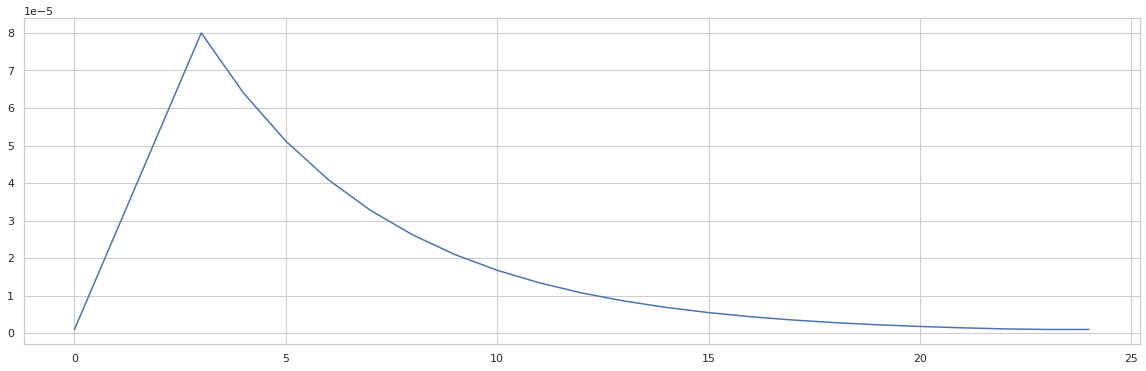

In [ ]:
LEARNING_RATE = 1e-5 * strategy.num_replicas_in_sync

def exponential_schedule_with_warmup(epoch):
    '''
    Create a schedule with a learning rate that decreases exponentially after linearly increasing during a warmup period.
    '''
    
    warmup_epochs=3
    hold_max_epochs=0
    lr_start=1e-6
    lr_max=LEARNING_RATE
    lr_min=1e-6
    decay=0.8
        
        
    if epoch < warmup_epochs:
        lr = (lr_max - lr_start) / warmup_epochs * epoch + lr_start
    elif epoch < warmup_epochs + hold_max_epochs:
        lr = lr_max
    else:
        lr = lr_max * (decay ** (epoch - warmup_epochs - hold_max_epochs))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)
            
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_schedule_with_warmup, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_schedule_with_warmup(x) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{EPOCHS} total epochs and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to { max(y):.3g} to { y[-1]:.3g}')

Learning rate schedule: 1e-05 to 0.0004 to 1.56e-05


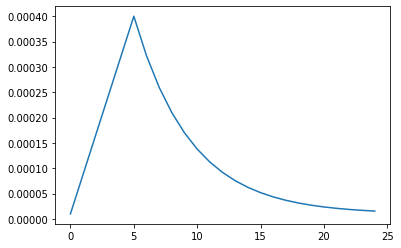

In [ ]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

# LR_START = 0.00001
# LR_MAX = 0.00005 * strategy.num_replicas_in_sync
# LR_MIN = 0.00001
# LR_RAMPUP_EPOCHS = 5
# LR_SUSTAIN_EPOCHS = 0
# LR_EXP_DECAY = .8

# def lrfn(epoch):
#     if epoch < LR_RAMPUP_EPOCHS:
#         lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
#     elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
#         lr = LR_MAX
#     else:
#         lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
#     return lr
    
# lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

# rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
# y = [lrfn(x) for x in rng]
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Building our model
In order to ensure that our model is trained on the TPU, we build it using `with strategy.scope()`.    

This model was built using transfer learning, meaning that we have a _pre-trained model_ (ResNet50) as our base model and then the customizable model built using `tf.keras.Sequential`. If you're new to transfer learning I recommend setting `base_model.trainable` to **False**, but _do_ encourage you to change which base model you're using (more options are available in the **[`tf.keras.applications` Module](https://www.tensorflow.org/api_docs/python/tf/keras/applications)** documentation) as well iterate on the custom model. 

Note that we're using `sparse_categorical_crossentropy` as our loss function, because we did _not_ one-hot encode our labels.

In [ ]:
with strategy.scope():
    img_adjust_layer = tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, input_shape=[*IMAGE_SIZE, 3])
    # data_augmentation_layer = Data_Augmentation()   
    base_model = tf.keras.applications.efficientnet.EfficientNetB4(weights='imagenet', include_top=False)
    # base_model.trainable = False

    model = tf.keras.Sequential([
        # tf.keras.layers.BatchNormalization(renorm=True),
        # data_augmentation_layer,
        img_adjust_layer,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(64, activation='relu'),
        #tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')  
    ])

    # model = SAMModel(model)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5*strategy.num_replicas_in_sync),
        loss='categorical_crossentropy',  
        metrics=['categorical_accuracy'])

# Train the model
As our model is training you'll see a printout for each epoch, and can also monitor TPU usage by clicking on the TPU metrics in the toolbar at the top right of your notebook.

In [ ]:
# load data
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

0
1
2
3
x


In [ ]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS*2,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks = [lr_callback])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
125/125 [==============================] - 186s 713ms/step - loss: 1.5827 - categorical_accuracy: 0.2539 - val_loss: 1.6332 - val_categorical_accuracy: 0.0549
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 2.7333333333333338e-05.
125/125 [==============================] - 77s 617ms/step - loss: 1.2152 - categorical_accuracy: 0.5734 - val_loss: 1.4907 - val_categorical_accuracy: 0.4066
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 5.366666666666667e-05.
125/125 [==============================] - 77s 620ms/step - loss: 1.0016 - categorical_accuracy: 0.6519 - val_loss: 1.6563 - val_categorical_accuracy: 0.1831
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(8e-05, shape=(), dtype=float32).
125/125 [==============================] - 78s 620ms/step - loss: 0.9276 - categorical_accuracy: 0.6746 - val_loss: 1.0137 - val_categor

With model.summary() we'll see a printout of each of our layers, their corresponding shape, as well as the associated number of parameters. Notice that at the bottom of the printout we'll see information on the total parameters, trainable parameters, and non-trainable parameters. Because we're using a pre-trained model, we expect there to be a large number of non-trainable parameters (because the weights have already been assigned in the pre-trained model).

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_8 (Lambda)            (None, 512, 512, 3)       0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, None, None, 2048)  28513527  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                131136    
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 325       
Total params: 28,644,988
Trainable params: 28,472,245
Non-trainable params: 172,743
_________________________________________________________________


# Evaluating our model
The first chunk of code is provided to show you where the variables in the second chunk of code came from. As you can see, there's a lot of room for improvement in this model, but because we're using TPUs and have a relatively short training time, we're able to iterate on our model fairly rapidly.

In [ ]:
# print out variables available to us
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


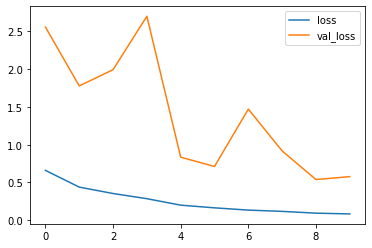

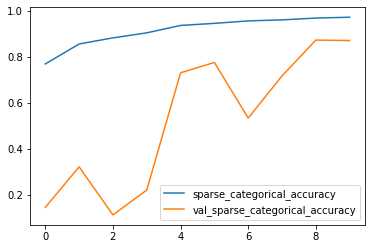

In [ ]:
# create learning curves to evaluate model performance
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

# Making predictions
Now that we've trained our model we can use it to make predictions! 

In [ ]:
# this code will convert our test image data to a float32 
def to_float32(image, label):
    return tf.cast(image, tf.float32), label

In [ ]:
test_ds = get_test_dataset(ordered=True) 
test_ds = test_ds.map(to_float32)
testing_dataset = get_test_dataset()
print('Computing predictions...')
test_images_ds = testing_dataset
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
[4]


# Creating a submission file
Now that we've trained a model and made predictions we're ready to submit to the competition! You can run the following code below to get your submission file.

In [ ]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
!head submission.csv

Generating submission.csv file...
id,label
2216849948.jpg,4


In [ ]:
! nvidia-smi

Thu Aug  5 00:16:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    39W / 300W |  15493MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------